In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
import plotly
import sklearn

from IPython.display import display

print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)
print("plotly:     ", plotly.__version__)

package版本信息：
numpy:       1.19.2
pandas:      1.2.1
matplotlib:  3.3.2
sklearn:     0.22.1
seaborn:     0.11.1
plotly:      4.14.1


In [18]:
from plotly.subplots import make_subplots

# 聚类分析

这里重点关注一下几种聚类算法和它们对应的sklearn实现:
1. K-means
2. Mean-shift
3. DBSCAN
4. 层次聚类法
5. Spectral Clustering（谱聚类）

In [19]:
from sklearn.datasets import make_blobs, make_biclusters, make_moons

# KMeans聚类  

## 数据集

In [20]:
# 构造一个数据集，特征数=2，一共 3 个中心，对应于 3 个簇
X, y= make_blobs(n_samples=300 ,n_features=2, centers=[[0,0],[1.5,4],[4,2.5]])
# X, y = make_moons(n_samples=300)

print(X.__class__, X.shape)
print(y.__class__, y.shape)

# 检查一下各个簇的样本数
print("----------------------------")
y_ = pd.Series(y)
print(y_.value_counts())

# 将特征的矩阵和对应的 簇标签 合并起来，方便绘图
print("----------------------------")
X_y = np.hstack([X,y.reshape(-1,1)])
print(X_y.shape)
X_y = pd.DataFrame(X_y, columns=['x1','x2','group'])

<class 'numpy.ndarray'> (300, 2)
<class 'numpy.ndarray'> (300,)
----------------------------
0    100
1    100
2    100
dtype: int64
----------------------------
(300, 3)


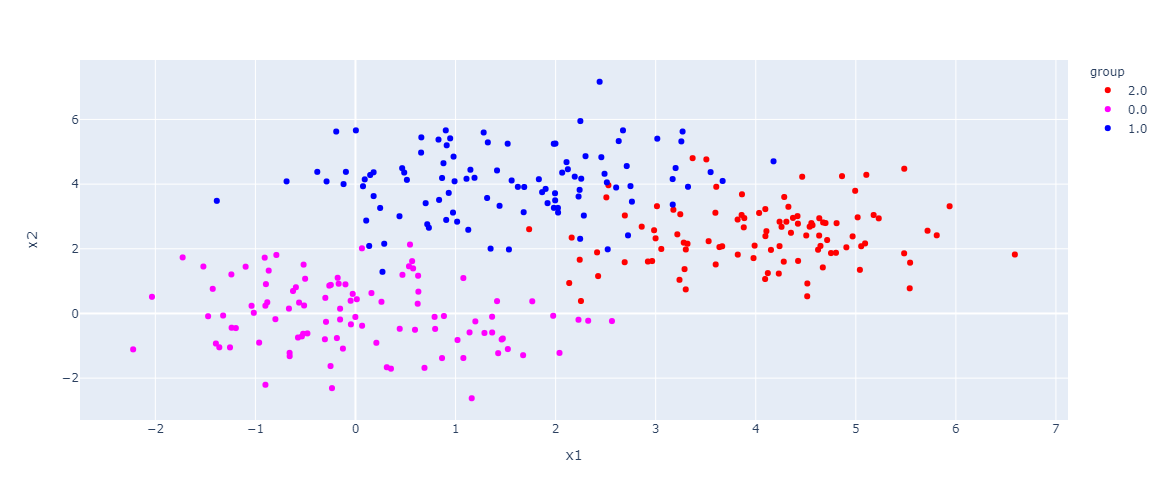

In [21]:
# sns.relplot(data=X_y, x='x1', y='x2', hue='group' )

# 将 簇标签 group 转成 字符型，避免绘制时作为连续变量映射到color
X_y['group'] = X_y['group'].astype(str)
# 这里自己指定了使用的离散色彩序列
fig = px.scatter(data_frame=X_y, x='x1', y='x2',color='group', color_discrete_sequence=["red", "magenta", "blue"])
fig.update_layout(width=800, height=500)
fig.show()

## Kmeans聚类

`KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, algorithm='auto')`
+ 参数
  + `init`,初始化算法，more是`k-means++`
  + `n_init`，使用不同质心进行运算的次数，默认=10


+ 属性
  + `cluster_centers_`，每个簇的质心
  + `labesl_`，每个样本对应的簇标号
  + `inertia_`，
  + `n_iter_`，迭代次数
  
如果数据量太大，可以使用一部分数据进行fit，然后使用predict来对剩余的数据进行聚类

In [22]:
# KMeans是类， k_means是函数
from sklearn.cluster import KMeans, k_means

In [23]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [24]:
kmeans.n_clusters

3

In [25]:
# 最终每一簇的质心
kmeans.cluster_centers_

array([[4.08520682, 2.4670939 ],
       [0.07385813, 0.02172962],
       [1.45396437, 4.1754029 ]])

In [26]:
kmeans.cluster_centers_[:,0]

array([4.08520682, 0.07385813, 1.45396437])

In [27]:
# 每个样本所属的簇标签
print(kmeans.labels_.shape)
kmeans.labels_[:5]

(300,)


array([0, 1, 2, 2, 1])

In [28]:
kmeans.inertia_

575.1124416934585

In [29]:
# 将原始数据和 聚类结果的簇标签结合起来，用于绘图
X_cluster = np.hstack([X, kmeans.labels_.reshape(-1,1)])
X_cluster = pd.DataFrame(X_cluster, columns=['x1','x2','cluster'])
X_cluster['cluster'] = X_cluster['cluster'].astype(str)

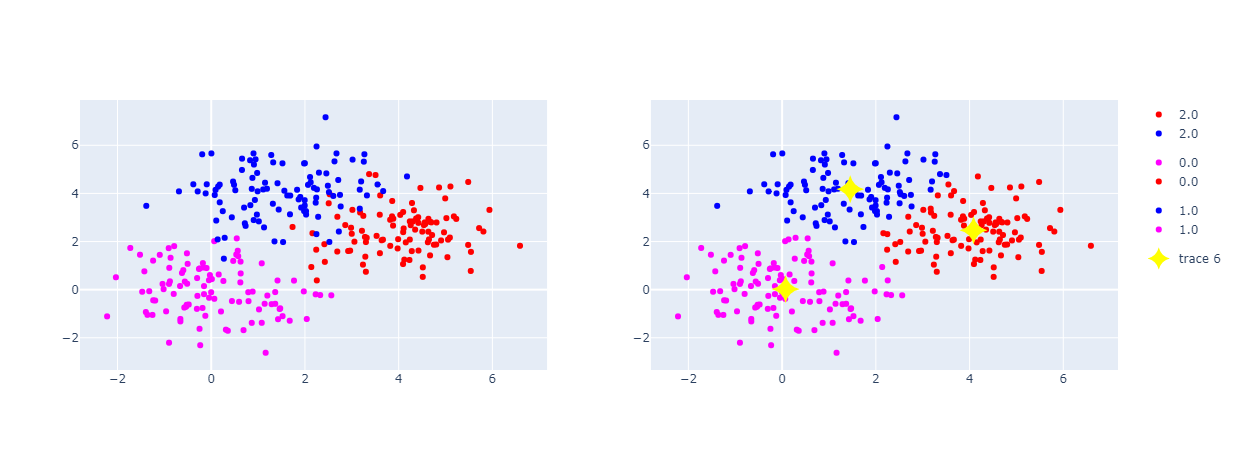

In [30]:
fig = make_subplots(rows=1, cols=2, column_widths=[600,600], row_heights=[600])

# 注意，这里 用于分组的 group 和 cluster 都是分类变量，所以返回的 fig1 和 fig2 里，都有 3 条 trace，对应于三个簇
fig1 = px.scatter(data_frame=X_y, x='x1', y='x2',color='group', color_discrete_sequence=["red", "magenta", "blue"])
fig2 = px.scatter(data_frame=X_cluster, x='x1', y='x2', color='cluster', color_discrete_sequence=["red", "magenta", "blue"])

# 这里不能使用 add_trace 方法，
fig.add_traces(fig1.data, rows=1, cols=1)
fig.add_traces(fig2.data, rows=1, cols=2)
fig.add_trace(
    go.Scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], 
               mode="markers",
               marker=dict(size=20, color='yellow', symbol='star-diamond')
    ), 
    row=1, col=2)

fig.show()

## KMeans聚类的效果评估

通常有两种方式：
1. “手肘”法
2. 轮廓系数



### 手肘法

`k` 从 1 取到 n (样本总数)，分别聚类，计算相应的簇内平方和（也就是 inertia），选择有拐点的那个k。

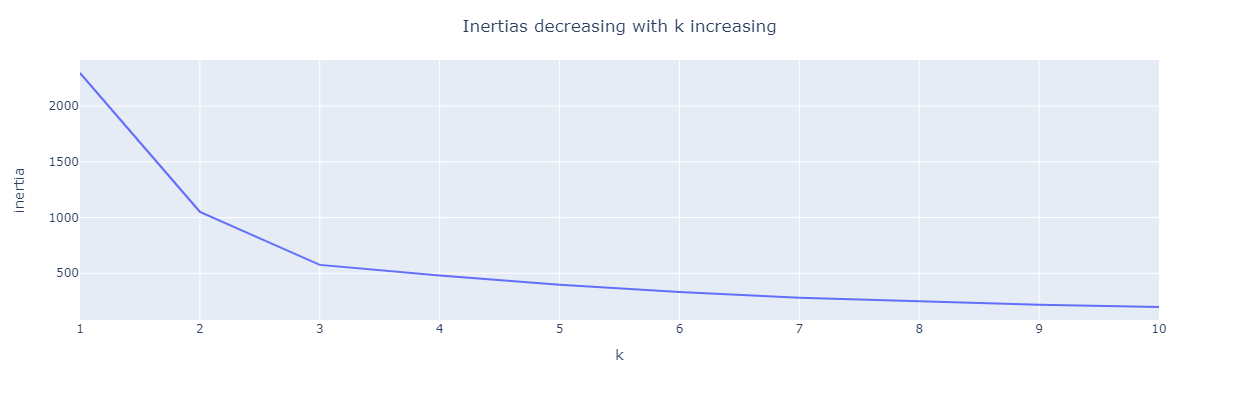

In [31]:
k_values = list(range(1, 11))
k_inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    k_inertias.append(kmeans.inertia_)
    
fig = px.line(x=k_values, y=k_inertias)
fig.update_layout(autosize=False, width=1000, height=400, xaxis_title="k", yaxis_title="inertia",
                  title=dict(text="Inertias decreasing with k increasing", x=0.5, y=0.95))
fig.show()

### 轮廓系数

对于单个样本 $s_i$ 来说，它的轮廓系数按照如下方式计算：
$$s_i = \frac{b_i-a_i}{max(a_i,b_i)}$$
$a_i$ 是样本到所在簇中其他点的平均距离，$b_i$ 是样本点到其他簇的点的平均距离。  
$s_i \in [-1, 1]$，越接近 1 ，表示聚类效果越好，越接近于 -1 表示聚类效果越差。

sklearn中，有两个函数可以用于计算轮廓系数，均位于`sklearn.metric`包中：
+ `silhouette_score(X, labels, *, metric='euclidean', sample_size=None)`, 计算的是整个样本集的轮廓系数均值
+ `silhouette_samples(X, labels)`, 计算的是每个样本的轮廓系数

sklearn官方文档里有一个介绍使用轮廓系数来选择最佳k值的教程 [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

In [33]:
# 计算整个数据集的轮廓系数均值
from sklearn.metrics import silhouette_score
# 计算每个样本的轮廓系数
from sklearn.metrics import silhouette_samples

In [34]:
s_score = silhouette_score(X, kmeans.labels_)
s_samples = silhouette_samples(X, kmeans.labels_)

print("s_score: ", s_score)
print("s_samples: ", s_samples[:5])

s_score:  0.3661152091493871
s_samples:  [0.28235759 0.587592   0.53758789 0.52057126 0.40966549]


绘制轮廓系数图----TODO

## Mini-Batch Kmeans

Kmeans的改进，每一轮中，使用随机抽样的mini-batches来减少计算时间，效果会差一点，但一般不会差很多.

`MiniBatchKMeans(n_clusters=8, *, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True, random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)`
+ 参数
  + `batch_size`，抽样的数据量

## MeanShift

`MeanShift(*, bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None, max_iter=300)`
+ 参数
  + `bandwitdh`,RBF kernel使用的bandwidth
  + 

## KMean聚类做矢量量化

这个是sklearn的官方文档教程 [Color Quantization using K-Means](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html)

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time
# 这个里面只有两张图片，一张颐和园的，一张花的
from sklearn.datasets import load_sample_image

<class 'numpy.ndarray'>
(427, 640, 3)


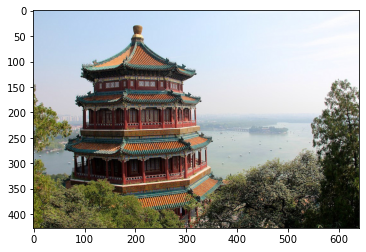

In [43]:
# 颐和园图片
picture = load_sample_image('china.jpg')
print(picture.__class__)
print(picture.shape)
plt.imshow(picture)

In [50]:
picture_ = picture.reshape(-1, 3)
picture_ = pd.DataFrame(picture_)
print(picture_.iloc[1, :])
print(picture_.shape)
print(picture_.drop_duplicates().shape)

0    174
1    201
2    231
Name: 1, dtype: uint8
(273280, 3)
(96615, 3)


上面这张图片的像素大小为 427 x 640，图像的颜色深度=3（RGB的255,255,255表示），一共有 9 万 6 千多种颜色，接下来，要使用 kmeans 来将颜色压缩到 64 种。  
具体的做法是，使用kmeans将 9w 种颜色聚成 64 个簇，然后使用这 64 个簇的簇心（RGB）来表示颜色。

In [57]:
# 将RGB表示转换成小数
picture_decode = np.array(picture, dtype=np.float64)/255
# 拉平
picture_flat = picture_decode.reshape(-1, 3)
# 为了加快计算时间，可以使用部分样本来聚类
picture_sample = shuffle(picture_flat, random_state=29)[:1000]

# 聚类
n_cluster = 64
kmeans = KMeans(n_cluster)
# kmeans.fit(picture_flat)
kmeans.fit(picture_sample)

# 获取每一簇的中心
centers = kmeans.cluster_centers_

# 获取每个样本对应的簇标签
# labels = kmeans.labels_
labels = kmeans.predict(picture_flat)

In [73]:
print(labels.shape)
print(centers.shape)
print(labels[:5])
print(centers[:5, :])

(273280,)
(64, 3)
[52 52 52 52 52]
[[0.82156863 0.74901961 0.75      ]
 [0.17603486 0.17124183 0.15337691]
 [0.92348584 0.9579085  0.99625272]
 [0.457041   0.43921569 0.2798574 ]
 [0.57037037 0.58082789 0.50675381]]


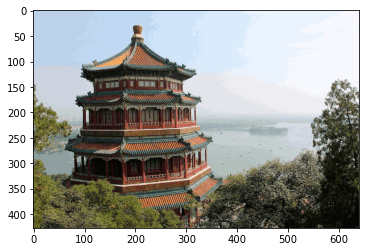

In [81]:
# 将原有数据中的颜色点 归到对应的簇中，并且使用对应簇的颜色来代替
w,h,d = picture.shape
picture_compress = picture_flat.copy()

for label_idx in range(w*h):
    picture_compress[label_idx] = centers[labels[label_idx]]
    
picture_compress = picture_compress.reshape(w,h,d)

# label_idx = 0
# for i in range(w):
#     for j in range(d):
#         picture_compress[i,j,:] = centers[labels[label_idx], :]
#         label_idx += 1

plt.imshow(picture_compress)

In [86]:
picture[:5,1,:]/255

array([[0.68235294, 0.78823529, 0.90588235],
       [0.67843137, 0.78431373, 0.90196078],
       [0.68235294, 0.78823529, 0.90588235],
       [0.68627451, 0.79215686, 0.90980392],
       [0.68235294, 0.78823529, 0.90196078]])

In [85]:
picture_compress[:5,1,:]

array([[0.73867334, 0.82386316, 0.92282019],
       [0.73867334, 0.82386316, 0.92282019],
       [0.73867334, 0.82386316, 0.92282019],
       [0.73867334, 0.82386316, 0.92282019],
       [0.73867334, 0.82386316, 0.92282019]])

-------------------

# DBSCAN

`DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)`
+ 参数
  + `eps`，定义为相邻点的半径
  + `min_samples`，定义核心点需要的相邻点个数
  + `metric`，计算距离的定义


+ 属性
  + `core_sample_indices_`, Indices of core samples
  + `components_`, shape=`(n_core_samples, n_features)`, 核心点
  + `labels_`, 聚类和每个点的簇标签，噪声点的标签为 -1.
  
 
sklearn官方有个示例文档 [Demo of DBSCAN clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py).

In [99]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [100]:
dbscan = DBSCAN(eps=0.5, min_samples=10)

In [102]:
# 构造一个数据集，特征数=2，一共 3 个中心，对应于 3 个簇
X, y= make_blobs(n_samples=300 ,n_features=2, centers=[[0,0],[1.5,4],[4,2.5]])
# 由于 eps 指定的距离是0.5，为了消除量纲的影响，需要做一次标准化
X = StandardScaler().fit_transform(X)

dbscan.fit(X)

DBSCAN(min_samples=10)

In [106]:
X.shape

(300, 2)

In [104]:
dbscan.core_sample_indices_[:5]

array([0, 1, 2, 3, 4], dtype=int64)

In [105]:
dbscan.components_.shape

(268, 2)

In [110]:
set(dbscan.labels_)

{-1, 0}

In [108]:
dbscan.labels_[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

---------------


# 层次聚类

`AgglomerativeClustering(n_clusters=2, *, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)`

+ 参数
  + `affinity`, 用于计算两个簇之间的相邻度指标,
  

+ 属性
  + `n_clusters_`, 簇的数量
  + `labels_`, 每个点的簇标签
  + `n_leaves_`, 层次树的节点个数
  + `n_connected_components_`,
  + `children_`, 
  + `distance_`